# Simulating data

In [129]:
import random
import numpy as np

## Parameters

In [ ]:
simulation_rules = {
    "personas": {
        "bargain_hunter": {
            "intent_probs": {"ask_price": 0.5, "compare": 0.3, "complain": 0.2},
            "conversion_probability": 0.15,
        },
        "curious": {
            "intent_probs": {"ask_features": 0.7, "ask_price": 0.2, "compare": 0.1},
            "conversion_probability": 0.05,
        },
        "decisive": {
            "intent_probs": {"ask_price": 0.4, "buy": 0.4, "ask_features": 0.2},
            "conversion_probability": 0.50,
        }
    },

    "intents": ["ask_price", "ask_features", "compare", "complain", "buy"],

    # Chatbot actions (what the agent can pick)
    "actions": ["give_price", "give_features", "make_discount", "upsell", "apologize", "close_offer"],

    # Transition probabilities (persona × action → intent shift)
    "transitions": {
        "give_price": {"buy": 0.3, "compare": 0.3, "ask_features": 0.4},
        "give_features": {"buy": 0.4, "ask_price": 0.4, "compare": 0.2},
        "make_discount": {"buy": 0.6, "ask_price": 0.2, "complain": 0.2},
        "upsell": {"ask_features": 0.4, "ask_price": 0.2, "compare": 0.4},
        "apologize": {"complain": 0.5, "ask_features": 0.3, "ask_price": 0.2},
        "close_offer": {"buy": 0.9}
    },

    # Reward shaping
    "rewards": {
        "conversion": 10.0,
        "intent_alignment": 1.0,
        "neutral": 0.0,
        "bad_move": -1.0
    }
}

In [ ]:
type(simulation_rules)

## Loading file

In [130]:
import json

In [131]:
def load_simulation_rules(path: str) -> dict:
    """Load simulation rules from a JSON file."""
    with open(path, "r") as f:
        return json.load(f)

In [132]:
# Usage
simulation_rules1 = load_simulation_rules("simulation_rules.json")
type(simulation_rules1)

dict

## Simulating a conversation

In [133]:
import pandas as pd
import random

def simulate_dataset(rules, agent, n_conversations=10000, max_steps=20):
    env = ConversationSimulator(rules)

    rows = []
    conversation_id = 0

    for _ in range(n_conversations):
        # pick persona at random
        persona = random.choice(list(rules["personas"].keys()))
        state = env.reset(persona)
        done = False
        step = 0

        while not done and step < max_steps:
            persona_name = env.persona
            intent_index = state[1]

            # agent chooses an action (persona-specific)
            action_index = agent.sample_action(persona_name, state)
            action_name = rules["actions"][action_index]

            # simulate next step
            next_state, reward, done = env.step(action_index)

            # record one row
            rows.append({
                "conversation_id": conversation_id,
                "step": step,
                "persona": persona_name,
                "intent": rules["intents"][intent_index],
                "action": action_name,
                "reward": reward,
                "done": done
            })

            state = next_state
            step += 1

        conversation_id += 1

    return pd.DataFrame(rows)

## Reinforcement Learning

In [134]:

class ConversationSimulator:
    def __init__(self, rules):
        self.rules = rules
        self.persona = None
        self.state = None  # = current intent

    def reset(self, persona=None):
        if persona is None:
            persona = random.choice(list(self.rules["personas"].keys()))

        self.persona = persona
        persona_conf = self.rules["personas"][persona]
        
        # sample initial intent
        intents = list(persona_conf["intent_probs"].keys())
        probs = list(persona_conf["intent_probs"].values())
        self.state = random.choices(intents, probs)[0]

        return self._encode_state()

    def step(self, action_index):
        actions = self.rules["actions"]
        action = actions[action_index]

        reward = 0
        done = False

        # check if conversion happens
        if self.state == "buy" and action == "close_offer":
            reward += self.rules["rewards"]["conversion"]
            done = True
            return self._encode_state(), reward, done

        # transition to next intent
        probs_dict = self.rules["transitions"].get(action, {})
        if probs_dict:
            intents = list(probs_dict.keys())
            probs = list(probs_dict.values())
            self.state = random.choices(intents, probs)[0]
        else:
            reward += self.rules["rewards"]["bad_move"]

        # reward if the action is aligned with the user intent
        if action.startswith("give") and "ask" in self.state:
            reward += self.rules["rewards"]["intent_alignment"]

        # force conversion test
        if random.random() < self.rules["personas"][self.persona]["conversion_probability"]:
            reward += self.rules["rewards"]["conversion"]
            done = True

        return self._encode_state(), reward, done

    def _encode_state(self):
        # one-hot encode persona + one-hot encode intent
        persona_index = list(self.rules["personas"]).index(self.persona)
        intent_index = self.rules["intents"].index(self.state)
        return (persona_index, intent_index)


In [135]:
class MultiPersonaQLearning:
    def __init__(self, rules, alpha=0.1, gamma=0.95, epsilon=0.2):
        self.rules = rules
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = rules["actions"]
        self.intents = rules["intents"]

        # Q-table per persona: persona → matrix [intent × action]
        self.Q = {
            persona: np.zeros((len(self.intents), len(self.actions)))
            for persona in rules["personas"]
        }

    def sample_action(self, persona, state):
        intent_index = state[1]
        if random.random() < self.epsilon:
            return random.randint(0, len(self.actions) - 1)
        qvals = self.Q[persona][intent_index]
        return int(np.argmax(qvals))

    def update(self, persona, state, action, reward, next_state):
        intent = state[1]
        next_intent = next_state[1]

        best_next = np.max(self.Q[persona][next_intent])

        self.Q[persona][intent][action] += self.alpha * (
            reward + self.gamma * best_next - self.Q[persona][intent][action]
        )


In [136]:
def train_multi_persona(rules, episodes=5000):
    env = ConversationSimulator(rules)
    agent = MultiPersonaQLearning(rules)

    for ep in range(episodes):
        persona = random.choice(list(rules["personas"].keys()))
        state = env.reset(persona)

        done = False
        while not done:
            action = agent.sample_action(persona, state)
            next_state, reward, done = env.step(action)
            agent.update(persona, state, action, reward, next_state)
            state = next_state

    return agent

In [137]:
def run_demo(agent, persona="bargain_hunter"):
    env = ConversationSimulator(simulation_rules)
    state = env.reset(persona)
    done = False
    steps = 0

    print(f"\n--- DEMO with persona: {persona} ---")

    while not done and steps < 15:
        action = agent.sample_action(persona, state)
        next_state, reward, done = env.step(action)

        print(
            f"Persona={env.persona}, "
            f"State={state}, "
            f"Action={simulation_rules['actions'][action]}, "
            f"Reward={reward}"
        )

        state = next_state
        steps += 1

## Starting simulations

In [138]:
agent = train_multi_persona(simulation_rules, episodes=8000)

In [139]:
# 2. Generate 10,000 simulated conversations
df = simulate_dataset(simulation_rules, agent, n_conversations=10000)

df.head()

,conversation_id,step,persona,intent,action,reward,done
0,0,0,bargain_hunter,complain,close_offer,0.0,False
1,0,1,bargain_hunter,buy,close_offer,10.0,True
2,1,0,decisive,buy,close_offer,10.0,True
3,2,0,bargain_hunter,compare,close_offer,0.0,False
4,2,1,bargain_hunter,buy,close_offer,10.0,True


In [140]:
run_demo(agent)


--- DEMO with persona: bargain_hunter ---
Persona=bargain_hunter, State=(0, 3), Action=close_offer, Reward=0
Persona=bargain_hunter, State=(0, 4), Action=close_offer, Reward=10.0


## Batch simulation

In [141]:
import random
import numpy as np
import pandas as pd
from functools import partial

In [142]:
# ---------------------------------------------------
# FAST batch simulator
# ---------------------------------------------------
def batch_simulate_conversations(
    rules, 
    agent, 
    n_users=1_000_000,          # number of users / conversations
    max_steps=10,               # short convos = faster / more scalable
    seed=42
):
    random.seed(seed)
    np.random.seed(seed)

    personas_list = list(rules["personas"].keys())
    intents_list = rules["intents"]
    actions_list = rules["actions"]

    persona_index_map = {p: i for i, p in enumerate(personas_list)}

    # Preallocate lists (VERY fast)
    user_ids = []
    conversation_ids = []
    steps = []
    personas = []
    intents = []
    actions = []
    rewards = []
    dones = []

    env = ConversationSimulator(rules)

    # MAIN LOOP
    for conv_id in range(n_users):

        # assign a USER ID (persistent)
        user_id = conv_id

        # pick persona
        persona = random.choice(personas_list)

        # reset environment
        state = env.reset(persona)
        intent_index = state[1]

        done = False

        for step in range(max_steps):

            # choose action via RL agent
            action_index = agent.sample_action(persona, state)
            action_name = actions_list[action_index]

            # step simulation
            next_state, reward, done = env.step(action_index)

            # record row (just append)
            user_ids.append(user_id)
            conversation_ids.append(conv_id)
            steps.append(step)
            personas.append(persona)
            intents.append(intents_list[intent_index])
            actions.append(action_name)
            rewards.append(float(reward))
            dones.append(done)

            # update to next state
            state = next_state
            intent_index = state[1]

            if done:
                break

    # build dataframe at the end (fastest way)
    df = pd.DataFrame({
        "user_id": user_ids,
        "conversation_id": conversation_ids,
        "step": steps,
        "persona": personas,
        "intent": intents,
        "action": actions,
        "reward": rewards,
        "done": dones
    })

    is_conversion = (df["done"] == True) & (df["reward"] >= simulation_rules["rewards"]["conversion"])
    conversion_reward = simulation_rules["rewards"]["conversion"]
    df["is_conversion"] = (df["done"]) & (df["reward"] >= conversion_reward)

    return df


In [143]:
# Train agent first
agent = train_multi_persona(simulation_rules, episodes=8000)

In [144]:
# Generate 1 million users
df = batch_simulate_conversations(
    simulation_rules,
    agent,
    n_users=1_000_000,
    max_steps=8
)

df.head()

,user_id,conversation_id,step,persona,intent,action,reward,done,is_conversion
0,0,0,0,decisive,ask_price,close_offer,10.0,True,True
1,1,1,0,bargain_hunter,compare,close_offer,0.0,False,False
2,1,1,1,bargain_hunter,buy,give_features,0.0,False,False
3,1,1,2,bargain_hunter,buy,close_offer,10.0,True,True
4,2,2,0,decisive,buy,close_offer,10.0,True,True


In [145]:
overall_rate = df["is_conversion"].mean()
print("Overall Conversion Rate:", overall_rate)


Overall Conversion Rate: 0.49234372211832234


In [146]:
df.head()

,user_id,conversation_id,step,persona,intent,action,reward,done,is_conversion
0,0,0,0,decisive,ask_price,close_offer,10.0,True,True
1,1,1,0,bargain_hunter,compare,close_offer,0.0,False,False
2,1,1,1,bargain_hunter,buy,give_features,0.0,False,False
3,1,1,2,bargain_hunter,buy,close_offer,10.0,True,True
4,2,2,0,decisive,buy,close_offer,10.0,True,True


### Conversion rate per persona

In [147]:
conversion_by_persona = (
    df.groupby("persona")["is_conversion"]
      .mean()
      .sort_values(ascending=False)
)

print(conversion_by_persona)

persona
decisive          0.688967
bargain_hunter    0.450195
curious           0.413015
Name: is_conversion, dtype: float64


### Conversion rate by first intent

In [148]:
first_steps = df[df["step"] == 0]

conversion_by_intent = (
    first_steps.groupby("intent")["is_conversion"]
               .mean()
               .sort_values(ascending=False)
)

print(conversion_by_intent)

intent
buy             0.916180
ask_price       0.259689
complain        0.152390
ask_features    0.149122
compare         0.124258
Name: is_conversion, dtype: float64


### Conversion Probability by Last Chatbot Action

In [149]:
last_rows = df.groupby("conversation_id").tail(1)

conv_by_action = (
    last_rows.groupby("action")["is_conversion"]
             .mean()
             .sort_values(ascending=False)
)

print(conv_by_action)

action
close_offer      0.999375
upsell           0.995161
give_price       0.994775
give_features    0.994251
apologize        0.994018
make_discount    0.993861
Name: is_conversion, dtype: float64


### Distribution of Conversation Length and Impact on Conversion

In [150]:
lengths = df.groupby("conversation_id").size()

len_df = pd.DataFrame({
    "conversation_id": lengths.index,
    "length": lengths.values
})

merge = len_df.merge(
    df.groupby("conversation_id")["is_conversion"].max(),
    left_on="conversation_id",
    right_index=True
)

conversion_by_length = (
    merge.groupby("length")["is_conversion"]
         .mean()
)

print(conversion_by_length)


length
1    1.000000
2    1.000000
3    1.000000
4    1.000000
5    1.000000
6    1.000000
7    1.000000
8    0.560234
Name: is_conversion, dtype: float64


### Conversion Probability by Persona × Intent

In [151]:
pivot = (
    df[df["step"] == 0]
    .groupby(["persona", "intent"])["is_conversion"]
    .mean()
    .unstack()
)

display(pivot)

intent,ask_features,ask_price,buy,compare,complain
persona,,,,,
bargain_hunter,NaN,0.149715,NaN,0.149069,0.15239
curious,0.049449,0.050544,NaN,0.050389,NaN
decisive,0.499767,0.500722,0.91618,NaN,NaN


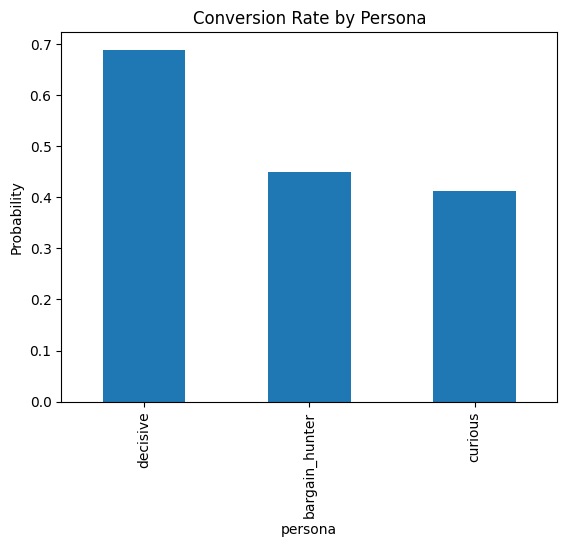

In [152]:
import matplotlib.pyplot as plt

conversion_by_persona.plot(kind="bar")
plt.title("Conversion Rate by Persona")
plt.ylabel("Probability")
plt.show()

## Conversion funnel analysis

In [153]:
def label_funnel_stage(intent):
    if intent in ["ask_features", "curious"]:
        return "interest"
    if intent in ["compare", "ask_price"]:
        return "consideration"
    if intent in ["bargain_hunter", "complain"]:
        return "evaluation"
    if intent in ["buy"]:
        return "decision"
    return "other"


In [154]:
df["stage"] = df["intent"].apply(label_funnel_stage)
df.tail(10)

,user_id,conversation_id,step,persona,intent,action,reward,done,is_conversion,stage
2028652,999993,999993,2,decisive,compare,give_price,0.0,False,False,consideration
2028653,999993,999993,3,decisive,buy,close_offer,10.0,True,True,decision
2028654,999994,999994,0,decisive,ask_price,close_offer,10.0,True,True,consideration
2028655,999995,999995,0,decisive,buy,close_offer,10.0,True,True,decision
2028656,999996,999996,0,bargain_hunter,compare,close_offer,0.0,False,False,consideration
2028657,999996,999996,1,bargain_hunter,buy,close_offer,10.0,True,True,decision
2028658,999997,999997,0,curious,ask_features,close_offer,0.0,False,False,interest
2028659,999997,999997,1,curious,buy,close_offer,10.0,True,True,decision
2028660,999998,999998,0,decisive,ask_price,close_offer,10.0,True,True,consideration
2028661,999999,999999,0,bargain_hunter,ask_price,close_offer,10.0,True,True,consideration


In [155]:
# last step per user
last_steps = df.groupby("user_id").tail(1)

# conversion logic
conversion_reward = simulation_rules["rewards"]["conversion"]
last_steps["is_conversion"] = (
    last_steps["done"] & (last_steps["reward"] >= conversion_reward)
)

# funnel % per stage
funnel_counts = df.groupby("stage")["user_id"].nunique()
funnel_percent = funnel_counts / df["user_id"].nunique()

print("Funnel conversion:", funnel_percent)

Funnel conversion: stage
consideration    0.557606
decision         0.800944
evaluation       0.100153
interest         0.339056
Name: user_id, dtype: float64


/var/folders/d_/82vq8df15ds9sym9kk86zlxm0000gp/T/ipykernel_1607/520970362.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_steps["is_conversion"] = (


In [156]:
last_steps.head()

,user_id,conversation_id,step,persona,intent,action,reward,done,is_conversion,stage
0,0,0,0,decisive,ask_price,close_offer,10.0,True,True,consideration
3,1,1,2,bargain_hunter,buy,close_offer,10.0,True,True,decision
4,2,2,0,decisive,buy,close_offer,10.0,True,True,decision
7,3,3,2,bargain_hunter,ask_features,give_price,10.0,True,True,interest
8,4,4,0,bargain_hunter,ask_price,close_offer,10.0,True,True,consideration


### Funnel drop-off

In [157]:
funnel_percent.diff().fillna(funnel_percent)

stage
consideration    0.557606
decision         0.243338
evaluation      -0.700791
interest         0.238903
Name: user_id, dtype: float64

In [158]:
persona_funnel = (
    df.groupby(["persona", "stage"])["user_id"]
      .nunique()
      .groupby(level=0)
      .apply(lambda x: x / x.sum())
)

persona_funnel

persona         persona         stage        
bargain_hunter  bargain_hunter  consideration    0.422705
                                decision         0.424706
                                evaluation       0.119656
                                interest         0.032933
curious         curious         consideration    0.185952
                                decision         0.445719
                                evaluation       0.023849
                                interest         0.344480
decisive        decisive        consideration    0.342809
                                decision         0.475834
                                evaluation       0.012479
                                interest         0.168878
Name: user_id, dtype: float64

## RL REWARD SENSITIVITY ANALYSIS

In [159]:
from copy import deepcopy

In [160]:
def train_under_reward_scale(scale):
    rules_scaled = deepcopy(simulation_rules)
    for r in rules_scaled["rewards"]:
        rules_scaled["rewards"][r] *= scale
    agent = train_multi_persona(rules_scaled, episodes=2000)
    df = batch_simulate_conversations(rules_scaled, agent, n_users=20000)
    return df["is_conversion"].mean()


In [161]:
def persona_sensitivity(scale):
    rules_scaled = deepcopy(simulation_rules)
    for r in rules_scaled["rewards"]:
        rules_scaled["rewards"][r] *= scale

    agent = train_multi_persona(rules_scaled, episodes=3000)
    df = batch_simulate_conversations(rules_scaled, agent, n_users=20000)

    return df.groupby("persona")["is_conversion"].mean()

In [162]:
for s in scales:
    print("Scale", s)
    print(persona_sensitivity(s))
    print()


Scale 0.25
persona
bargain_hunter    0.0
curious           0.0
decisive          0.0
Name: is_conversion, dtype: float64

Scale 0.5
persona
bargain_hunter    0.0
curious           0.0
decisive          0.0
Name: is_conversion, dtype: float64

Scale 1.0
persona
bargain_hunter    0.337867
curious           0.360487
decisive          0.689340
Name: is_conversion, dtype: float64

Scale 2.0
persona
bargain_hunter    0.340020
curious           0.359228
decisive          0.500761
Name: is_conversion, dtype: float64

Scale 4.0
persona
bargain_hunter    0.355377
curious           0.338739
decisive          0.506708
Name: is_conversion, dtype: float64



## Persona segmentation

Extracting per-user features

In [163]:
user_features = df.groupby("user_id").agg({
    "step": "max",
    "intent": lambda x: x.mode()[0],
    "action": lambda x: x.mode()[0],
    "reward": "sum",
    "is_conversion": "max"
}).reset_index()

user_features

,user_id,step,intent,action,reward,is_conversion
0,0,0,ask_price,close_offer,10.0,True
1,1,2,buy,close_offer,10.0,True
2,2,0,buy,close_offer,10.0,True
3,3,2,ask_features,close_offer,10.0,True
4,4,0,ask_price,close_offer,10.0,True
...,...,...,...,...,...,...
999995,999995,0,buy,close_offer,10.0,True
999996,999996,1,buy,close_offer,10.0,True
999997,999997,1,ask_features,close_offer,10.0,True
999998,999998,0,ask_price,close_offer,10.0,True


In [164]:
user_features_encoded = pd.get_dummies(
    user_features,
    columns=["intent", "action"],
    drop_first=True
)

user_features_encoded

,user_id,step,reward,is_conversion,intent_ask_price,intent_buy,intent_compare,intent_complain,action_close_offer,action_give_features,action_give_price,action_make_discount,action_upsell
0,0,0,10.0,True,True,False,False,False,True,False,False,False,False
1,1,2,10.0,True,False,True,False,False,True,False,False,False,False
2,2,0,10.0,True,False,True,False,False,True,False,False,False,False
3,3,2,10.0,True,False,False,False,False,True,False,False,False,False
4,4,0,10.0,True,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,0,10.0,True,False,True,False,False,True,False,False,False,False
999996,999996,1,10.0,True,False,True,False,False,True,False,False,False,False
999997,999997,1,10.0,True,False,False,False,False,True,False,False,False,False
999998,999998,0,10.0,True,True,False,False,False,True,False,False,False,False


### K-means clustering

In [165]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [166]:
scaler = StandardScaler()
X = scaler.fit_transform(user_features_encoded.drop(["user_id"], axis=1))

In [167]:

kmeans = KMeans(n_clusters=5, random_state=0)
user_features["cluster"] = kmeans.fit_predict(X)

user_features.head()

,user_id,step,intent,action,reward,is_conversion,cluster
0,0,0,ask_price,close_offer,10.0,True,0
1,1,2,buy,close_offer,10.0,True,3
2,2,0,buy,close_offer,10.0,True,3
3,3,2,ask_features,close_offer,10.0,True,0
4,4,0,ask_price,close_offer,10.0,True,0


- Cluster 0: Decisive buyers
- Cluster 1: Info seekers
- Cluster 2: Bargain hunters
- Cluster 3: Negative sentiment users
- Cluster 4: Lost / dropouts

### Predicting persona using classifier

In [168]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X, user_features["cluster"])
importance = clf.feature_importances_

In [169]:
new_user = user_features_encoded.sample(1)#.drop(["user_id"])
new_user.drop(["user_id"], axis=1, inplace=True)
new_user

,step,reward,is_conversion,intent_ask_price,intent_buy,intent_compare,intent_complain,action_close_offer,action_give_features,action_give_price,action_make_discount,action_upsell
57024,1,10.0,True,False,True,False,False,True,False,False,False,False


In [170]:
new_user_sc = scaler.fit_transform(new_user)
pred = clf.predict(new_user_sc)
pred

array([0], dtype=int32)

## Creating a persona

In [171]:
import ollama
from IPython.display import Markdown

In [172]:
new_user_str = new_user.to_string()
new_user_str

'       step  reward  is_conversion  intent_ask_price  intent_buy  intent_compare  intent_complain  action_close_offer  action_give_features  action_give_price  action_make_discount  action_upsell\n57024     1    10.0           True             False        True           False            False                True                 False              False                 False          False'

In [173]:
response_llm = ollama.chat(model='llama3.2', messages=[
    {'role': 'system',
     'content': 'you are a data analyst that helps interpret data and generate insights.'},
    {'role': 'user',
     'content': f'Here is the data used to create a persona: {new_user_str}. Can you help me to create it adding a profile summary and buying behaviours, goalas and motivations and pain pointst?'}])

In [174]:
display(Markdown(response_llm['message']['content']))

Based on the provided data, I'll help create a persona using the additional information you requested.

**Persona Name:** Emma

**Demographics:**

* Age: 28-35
* Occupation: Marketing Professional or Small Business Owner
* Location: Urban areas (e.g., New York City, San Francisco)
* Income: Middle to upper-middle class ($50,000 - $100,000)

**Profile Summary:**
Emma is a busy marketing professional and small business owner who values convenience, flexibility, and personalized experiences. She is tech-savvy and actively seeks out solutions that simplify her life.

**Buying Behaviors:**

* Emma prefers to shop online and uses her smartphone to research products and services.
* She is likely to read reviews from multiple sources before making a purchase decision.
* Her primary purchasing channels are social media, email marketing, and search engines.
* Emma values convenience and speed when shopping; she wants to quickly find what she needs and complete the transaction.

**Goals:**
Emma's short-term goals include:

1. Finding products or services that meet her specific needs.
2. Receiving personalized recommendations based on her purchasing history and preferences.
3. Easily navigating online platforms with minimal friction.

Long-term goals include:

1. Building a strong brand reputation through high-quality products and exceptional customer experiences.
2. Increasing sales and revenue while maintaining profitability.
3. Staying up-to-date with industry trends and emerging technologies to stay ahead in the market.

**Motivations:**
Emma is motivated by:

1. Convenience and time-saving features that simplify her shopping experience.
2. Personalized recommendations and tailored suggestions based on her preferences.
3. Trusting brands that demonstrate a commitment to quality, customer satisfaction, and innovation.

**Pain Points:**

1. Information overload from multiple sources, leading to difficulty making informed purchasing decisions.
2. Lack of trust in online reviews or ratings systems, which can impact product credibility.
3. Technical issues or slow load times on websites, resulting in frustration and abandonment.
4. Limited availability of products or services that meet her specific needs.

**Intent Analysis:**

Based on the original data, we can infer Emma's intent:

* She has shown an interest in rewards (step 1) but may not be convinced to make a purchase without additional value or incentives.
* Her desire for price comparison (intent_compare) suggests she values transparency and wants to make informed purchasing decisions.
* Emma is more likely to buy from businesses that offer flexible pricing options (action_give_price) and make her feel valued as a customer.

This persona summary provides a foundation for understanding Emma's needs, preferences, and behaviors. It can be used to inform product development, marketing strategies, and customer service initiatives to better serve this target audience.

How does this align with your expectations? Would you like me to add or modify anything?